## Evaluating Predictive Performance

Topics presented here:

- Discussion on popular performance metrics. For prediction, metrics include Average Error, MAPE, and RMSE (based on the validation data). For classification tasks, metrics based on the confusion matrix include overall accuracy, specificity and sensitivity, and metrics that account for misclassification costs.

- Relation between the choice of cutoff value and classification performance, and present the ROC (Receiver Operating Characteristic) curve, which is a popular chart for assessing method performance at different cutoff values.
 
- Lift charts. Used when the goal is to accurately classify the most interesting or important records, called ranking, rather than accurately classify the entire sample (e.g., the 10% of customers most likely to respond to an offer, or the 5% of claims most likely to be fraudulent)

- the usefulness of comparing metrics based on the validation data to those based on the training data for the purpose of detecting overfitting. While some differences are expected, extreme differences can be indicative of overfitting.

# Modules

In [1]:
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

import matplotlib.pylab as plt
from utils import regression_summary, gains_chart, lift_chart
from utils import classification_summary

## Introduction 

Three main types of outcomes of interest are:

- Predicted numerical value: when the outcome variable is numerical (e.g., house price)

- Predicted class membership: when the outcome variable is categorical (e.g., buyer/nonbuyer)

- Propensity: the probability of class membership, when the outcome variable is categorical (e.g., the propensity to default)

Prediction methods are used for generating numerical predictions, while classification methods (“classifiers”) are used for generating propensities and, using a cutoff value on the propensities, we can generate predicted class memberships.

A subtle distinction to keep in mind is the two distinct predictive uses of classifiers: one use, classification, is aimed at predicting class membership for new records. The other, ranking, is detecting among a set of new records the ones most likely to belong to a class of interest.

### Evaluating Predictive Performance 

First, let us emphasize that predictive accuracy is not the same as goodness-of-fit. Classical statistical measures of performance are aimed at finding a model that fits well to the data on which the model was trained. In data mining, we are interested in models that have high predictive accuracy when applied to new records.

Measures such as $R^2$ and standard error of estimate are common metrics in classical regression modeling, and residual analysis is used to gauge goodness-of-fit in that situation. However, these measures do not tell us much about the ability of the model to predict new records.

For assessing prediction performance, several measures are used. In all cases, the measures are based on the validation set, which serves as a more objective ground than the training set to assess predictive accuracy. This is because records in the validation set are more similar to the future records to be predicted, in the sense that they are not used to select predictors or to estimate the model parameters. Models are trained on the training set, applied to the validation set, and measures of accuracy then use the prediction errors on that validation set.

### Naive Benchmark: The Average

The benchmark criterion in prediction is using the average outcome value (thereby ignoring all predictor information). In other words, the prediction for a new record is simply the average across the outcome values of the records in the training set ($\bar{y}$). This is sometimes called a naive benchmark. A good predictive model
should outperform the benchmark criterion in terms of predictive accuracy.

### Prediction Accuracy Measures

The prediction error for record $i$ is defined as the difference between its actual outcome value and its predicted outcome value: $e_{i} = y_{i} - \hat{y}_i$

A few popular numerical measures of predictive accuracy are:

- **MAE** (mean absolute error/deviation) = $\frac{1}{n}\sum^{n}_{i=1}|{e}|$

    This gives the magnitude of the average absolute error.


- **Mean Error** = $\frac{1}{n}\sum^{n}_{i=1}e_{i}$

    This measure is similar to MAE except that it retains the sign of the errors, so that negative errors cancel out positive errors of the same magnitude. It therefore gives an indication of whether the predictions are on average over - or underpredicting the outcome variable.


- **MPE** (mean percentage error) = 100 x $\frac{1}{n}\sum^{n}_{i=1}\frac{e_{i}}{y_{i}}$

    This gives the percentage score of how predictions deviate from the actual values (on average), taking into account the direction of the error.


- **MAPE** (mean absolute percentage error) = 100 x $\frac{1}{n}\sum^{n}_{i=1}|\frac{e_{i}}{y_{i}}|$

    This measure gives a percentage score of how predictions deviate (on average) from the actual values.


- **RMSE** (root mean squared error) = $\sqrt{\frac{1}{n}\sum^{n}_{i=1}e^{2}_{i}}$

    This is similar to the standard error of estimate in linear regression, except that it is computed on the validation data rather than on the training data. It has the same units as the outcome variable.


Such measures can be used to compare models and to assess their degree of prediction accuracy. Note that all these measures are influenced by outliers. To check outlier influence, we can compute median-based measures (and compare to the above mean-based measures) or simply plot a histogram or boxplot of the errors. Plotting the prediction errors’ distribution is in fact very useful and can highlight more information than the metrics alone.

To illustrate the use of predictive accuracy measures and charts of prediction error distribution, consider the error metrics and charts that follows:

In [2]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv("../datasets/ToyotaCorolla.csv")

# create a list of predictor variables by removing output variables and text columns
excluded_columns = ("Price", "Id", "Model", "Fuel_Type", "Color")
predictors = [s for s in car_df.columns if s not in excluded_columns]
outcome = "Price"

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regression_summary(train_y, reg.predict(train_X))
# validation
regression_summary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


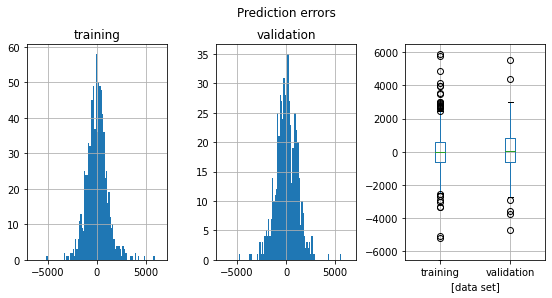

In [3]:
pred_error_train = pd.DataFrame({
    "residual": train_y - reg.predict(train_X),
    "data set": "training"})

pred_error_valid = pd.DataFrame({
    "residual": valid_y - reg.predict(valid_X),
    "data set": "validation"})

boxdata_df = pred_error_train.append(pred_error_valid, ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)

common = {"bins": 100, "range": [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by="data set")

axes[0].set_title("training")
axes[1].set_title("validation")
axes[2].set_title(" ")
axes[2].set_ylim(-6500, 6500)

plt.suptitle("Prediction errors")
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35)
plt.show()

These are the result of fitting a certain predictive model to prices of used Toyota Corolla cars. The training set includes 861 cars and the validation set includes 575 cars. Results are displayed separately for the training and validation sets. We can see from the histogram and boxplot corresponding to the validation set that most errors are in the [−2000, 2000] range.

### Comparing Training and Validation Performance

Errors that are based on the training set tell us about model fit, whereas those that are based on the validation set (called “prediction errors”) measure the model’s ability to predict new data (predictive performance).

We expect training errors to be smaller than the validation errors (because the model was fitted using the training set), and the more complex the model, the greater the likelihood that it will *overfit* the training data (indicated by a greater difference between the training and validation errors). In an extreme case of overfitting, the training errors would be zero (perfect fit of the model to the training data), and the validation errors would be non-zero and non-negligible.

For this reason, it is important to compare the error plots and metrics (RMSE, MAE, etc.) of the training and
validation sets. The above results show this: the training set performance measures appear slightly lower (better) than those for the validation set and the charts in which reveal more than the metrics alone, show a similar distribution of errors in the training and validation sets.

### Cumulative Gains and Lift Charts

In some applications, the goal is to search, among a set of new records, for a subset of records that gives the highest cumulative predicted values. In such cases, a graphical way to assess predictive performance is through the *cumulative gains* chart and *lift chart*. This compares the model’s predictive performance to a baseline
model that has no predictors.

Cumulative gains and lift charts for a continuous response are relevant only when we are searching for a set of records that gives the highest cumulative predicted values. Such charts are not relevant if we are interested in predicting the outcome value for *each* new record. The cumulative gains and lift charts are based on ordering the set of records of interest (typically validation data) by their predicted value, from high to low (called *ranking*). Then, we accumulate the actual values and plot their cumulative value (=gains) on the y-axis as a function of the number of records accumulated (the x-axis value). This is the *cumulative gains* curve. This curve is compared to assigning a naive prediction ($\hat{y}$) to each record and accumulating these average values, which results in a diagonal line.

The further away the cumulative gains curve from the diagonal benchmark line, the better the model is doing in separating records with high value outcomes from those with low value outcomes. The same information can be presented in a decile lift chart, where the ordered records are grouped into 10 deciles, and for each decile, the chart presents the ratio of model gains to naive benchmark gains, which is called *lift*.

The following figures show a cumulative gain chart and a decile lift chart based on fitting a linear regression model to the Toyota data. The charts are based on the validation data of 575 cars.

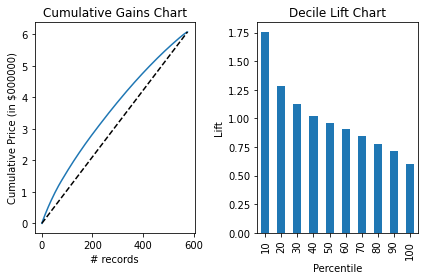

In [4]:
pred_v = pd.Series(reg.predict(valid_X))
pred_v = pred_v.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gains_chart(pred_v / 1000000, ax=axes[0])
ax.set_ylabel("Cumulative Price (in $000000)")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_v, ax=axes[1], label_bars=False)
ax.set_ylabel("Lift")

plt.tight_layout()
plt.show()

It can be seen that the model’s predictive performance in terms of gains is better than the baseline model, since its cumulative gains curve is higher than that of the baseline model. The above charts would be useful in the following scenario: choosing the top 10% of the cars that gave the highest predicted sales, for example, we would gain 1.75 times the amount of revenue, compared to choosing 10% of the cars at random. This lift number can also be computed from the cumulative gains chart by comparing the sales for 57 random cars (the value of the baseline curve at x = 57), which is \\$607,703 (= the sum of the actual sales for the 575 validation set cars divided by 10) with the actual sales of the 40 cars that have the highest predicted values (the value of the cumulative gains curve at x = 57), \\$1,073,830. The ratio between these numbers is 1.76.

## Judging classifier performance

A natural criterion for judging the performance of a classifier is the probability of making a *misclassification error*. Misclassification means that the record belongs to one class but the model classifies it as a member of a different class. A classifier that makes no errors would be perfect, but we do not expect to be able to construct such classifiers in the real world due to “noise” and not having all the information needed to classify records precisely. Is there a minimal probability of misclassification that we should require of a classifier?

### Benchmark: The Naive Rule

A very simple rule for classifying a record into one of $m$ classes, ignoring all predictor information ($x_1$, $x_2$, $…$, $x_p$) that we may have, is to classify the record as a member of the majority class. In other words, “classify as belonging to the most prevalent class.” The *naive rule* is used mainly as a baseline or benchmark for evaluating the performance of more complicated classifiers. Clearly, a classifier that uses external predictor information (on top of the class membership allocation) should outperform the naive rule. There are various
performance measures based on the naive rule that measure how much better than the naive rule a certain classifier performs.

Similar to using the sample mean ($\hat{y}$) as the naive benchmark in the numerical outcome case, the naive rule for classification relies solely on the $y$ information and excludes any additional predictor information.

### Class Separation

If the classes are well separated by the predictor information, even a small dataset will suffice in finding a good classifier, whereas if the classes are not separated at all by the predictors, even a very large dataset will not help. The following figure illustrates this for a two-class case. The above panel includes a small dataset (n = 24 records) where two predictors (income and lot size) are used for separating owners from nonowners. Here, the predictor information seems useful in that it separates the two classes (owners/nonowners). The bottom panel shows a much larger dataset (n = 5000 records) where the two predictors (income and monthly average credit card spending) do not separate the two classes well in most of the higher ranges (has credit card / does not have credit card).

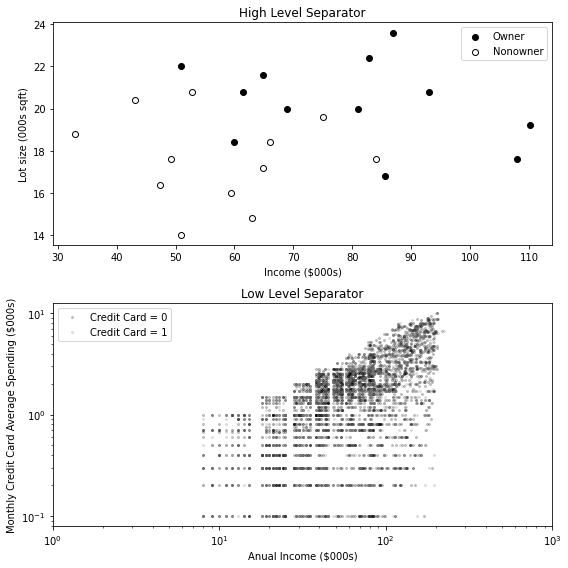

In [5]:
mowers_df = pd.read_csv("../datasets/RidingMowers.csv")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
for cat_value, color in [("Owner", "black"), ("Nonowner", "white")]:
    subset_df = mowers_df[mowers_df.Ownership == cat_value]
    axes[0].scatter(x=subset_df.Income, y=subset_df.Lot_Size, edgecolors="black",
                    c=color)
axes[0].set_ylabel("Lot size (000s sqft)")
axes[0].set_xlabel("Income ($000s)")
axes[0].set_title("High Level Separator")
axes[0].legend(["Owner", "Nonowner"])


universal_df = pd.read_csv("../datasets/UniversalBank.csv")

for cat_value, color in [(0, "black"), (1, "gray")]:
    subset_df = universal_df[universal_df["CreditCard"] == cat_value]
    axes[1].scatter(subset_df.Income,
                    subset_df.CCAvg,
                    marker="o", color=color, alpha=0.2, s=4)
    
axes[1].set_ylabel("Monthly Credit Card Average Spending ($000s)")
axes[1].set_xlabel("Anual Income ($000s)")
axes[1].set_title("Low Level Separator")
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].set_xlim([1, 1000])
axes[1].legend(["Credit Card = 0", "Credit Card = 1"])

plt.tight_layout()
plt.show()

### The Confusion (Classification) Matrix

In practice, most accuracy measures are derived from the *confusion matrix*, also called *classification matrix*. This matrix summarizes the correct and incorrect classifications that a classifier produced for a certain dataset. Rows and columns of the confusion matrix correspond to the predicted and true (actual) classes, respectively. The following table shows an example of a classification (confusion) matrix for a two-class (0/1) problem resulting from applying a certain classifier to 3000 records. The two diagonal cells (upper left, lower right) give the number of correct classifications, where the predicted class coincides with the actual class of the record. The off-diagonal cells give counts of misclassification. The lower left cell gives the number of class 1 members that were misclassified as 0’s (in this example, there were 85 such misclassifications). Similarly, the upper right cell gives the number of class 0 members that were misclassified as 1’s (25 such records).


|                   | Pred. Class 0    | Pred. Class 1   |
|:------------------|:-----------------|:----------------|
| **Actual Class 0**| 2689             | 25              |
| **Actual Class 1**| 85               | 201             |

In Python, we can obtain a confusion matrix using the function `confusion_matrix()` in the `scikit-learn` package. This function creates the cross-tabulation of actual and predicted classes.


### Using the Validation Data

To obtain an honest estimate of future classification error, we use the confusion matrix that is computed from the *validation data*. In other words, we first partition the data into training and validation sets by random selection of records. We then construct a classifier using the training data, and then apply it to the validation data. This will yield the predicted classifications for records in the validation set. We then summarize these classifications in a confusion matrix. Although we can summarize our results in a confusion matrix for training data as well, the resulting confusion matrix is not useful for getting an honest estimate of the misclassification rate for new data due to the danger of overfitting.

In addition to examining the validation data confusion matrix to assess the classification performance on new data, we compare the training data confusion matrix to the validation data confusion matrix, in order to detect overfitting: although we expect somewhat inferior results on the validation data, a large discrepancy in training and validation performance might be indicative of overfitting.

### Accuracy Measures

Different accuracy measures can be derived from the classification matrix. Consider a two-class case with classes $C_1$ and $C_2$ (e.g., buyer/non-buyer). The schematic confusion matrix below uses the notation $n_{i, j}$ to denote the number of records that are class $C_i$ members and were classified as $C_j$ members. Of course, if $i ≠ j$, these are counts of misclassifications. The total number of records is $n = n_{1, 1} + n_{1, 2} + n_{2, 1} + n_{2, 2}$.


| Actual (row) / Pred. (col) | $C_1$                                                         | $C_2$      |
|:---------------|:--------------------------------------------------------------|:-----------------------|
| **$C_1$** | $n_{1,1}$ = number of $C_1$ class. correctly | $n_{1,1}$ = number of $C_1$ class. as $C_2$  |
| **$C_2$** | $n_{2,1}$ = number of $C_2$ class. as $C_1$  | $n_{2,2}$ = number of $C_2$ class. correctly |


A main accuracy measure is the *estimated misclassification rate*, also called the *overall error rate*. It is given by:

<p><center>$err = \frac{n_{1, 2} + n_{2, 1}}{n}$</center></p>

where $n$ is the total number of records in the validation dataset.

In [6]:
# in the above example we have
err = (25 + 85) / 3000
err

0.03666666666666667

Or 3.67%.

We can measure accuracy by looking at the correct classifications — the full half of the cup—instead of the misclassifications. The *overall accuracy* of a classifier is estimated by:


<p><center>$acc = 1 - err = \frac{n_{1, 1} + n_{2, 2}}{n}$</center></p>

In [7]:
# in the example we have
acc = (2689 + 201) / 3000
acc

0.9633333333333334

Or 96.34%

### Propensities and Cutoff for Classification

The first step in most classification algorithms is to estimate the probability that a record belongs to each of the classes. These probabilities are also called *propensities*. Propensities are typically used either as an interim step for generating predicted class membership (classification), or for rank-ordering the records by their probability of belonging to a class of interest.

If overall classification accuracy (involving all the classes) is of interest, the record can be assigned to the class with the highest probability. In many records, a single class is of special interest, so we will focus on that particular class and compare the propensity of belonging to that class to a *cutoff value* set by the analyst. This approach can be used with two classes or more than two classes, though it may make sense in such cases to consolidate classes so that you end up with two: the class of interest and all other classes. If the probability of belonging to the class of interest is above the cutoff, the record is assigned to that class.

The default cutoff value in two-class classifiers is 0.5. Thus, if the probability of a record being a class $C_1$ member is greater than 0.5, that record is classified as a $C_1$ . Any record with an estimated probability of less than 0.5 would be classified as a $C_2$ . It is possible, however, to use a cutoff that is either higher or lower than 0.5. A cutoff greater than 0.5 will end up classifying fewer records as $C_1$’s, whereas a cutoff less than 0.5 will end up classifying more records as $C_1$ . Typically, the misclassification rate will rise in either case.

Consider the following data:

In [8]:
owner_df = pd.read_csv("../datasets/ownerExample.csv")
owner_df

,Class,Probability
0,owner,0.9959
1,owner,0.9875
2,owner,0.9844
3,owner,0.9804
4,owner,0.9481
5,owner,0.8892
6,owner,0.8476
7,nonowner,0.7628
8,owner,0.7069
9,owner,0.6807


That shows the actual class for 24 records, sorted by the probability that the record is an “owner” (as estimated by a data mining algorithm). If we adopt the standard 0.5 as the cutoff, our misclassification rate is 3/24, whereas if we instead adopt a cutoff of 0.25, we classify more records as owners and the misclassification rate goes up (comprising more nonowners misclassified as owners) to 5/24. Conversely, if we adopt a cutoff of 0.75, we classify fewer records as owners. The misclassification rate goes up (comprising more owners misclassified as nonowners) to 6/24. All this can be seen in the following classification table:

In [9]:
# cutoff = 0.5
predicted = ["owner" if p > 0.5 else "nonowner" for p in owner_df.Probability]
classification_summary(owner_df.Class, predicted, class_names=["nonowner", "owner"])
print()

# cutoff = 0.25
predicted = ["owner" if p > 0.25 else "nonowner" for p in owner_df.Probability]
classification_summary(owner_df.Class, predicted, class_names=["nonowner", "owner"])
print()

# cutoff = 0.75
predicted = ["owner" if p > 0.75 else "nonowner" for p in owner_df.Probability]
classification_summary(owner_df.Class, predicted, class_names=["nonowner", "owner"])
print()

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7



To see the entire range of cutoff values and how the accuracy or misclassification rates change as a function of the cutoff, we can plot the performance measure of interest vs. the cutoff. The results are shown below:

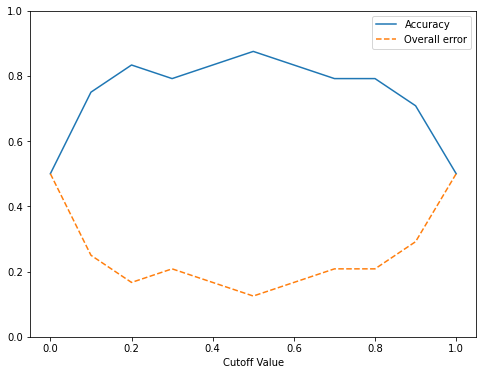

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

cutoffs = [i * 0.1 for i in range(0, 11)]
acc_t = []

for cutoff in cutoffs:
    predicted = ["owner" if p > cutoff else "nonowner" for p in owner_df.Probability]
    acc_t.append(accuracy_score(owner_df.Class, predicted))

line_accuracy = ax.plot(cutoffs, acc_t, "-", label="Accuracy")
line_error = ax.plot(cutoffs, [1 - acc for acc in acc_t], "--", label="Overall error")

ax.set_ylim([0, 1])
ax.set_xlabel("Cutoff Value")
plt.legend()
plt.show()

We can see that the accuracy level is pretty stable around 0.8 for cutoff values between 0.2 and 0.8.

Why would we want to use cutoff values different from 0.5 if they increase the misclassification rate? The answer is that it might be more important to classify owners properly than nonowners, and we would tolerate a greater misclassification of the latter. Or the reverse might be true; in other words, the costs of misclassification might be asymmetric. We can adjust the cutoff value in such a case to classify more records as the high-value class, that is, accept more misclassifications where the misclassification cost is low. Keep in mind that we are doing so after the data mining model has already been selected — we are not changing that model. It is also possible to incorporate costs into the picture before deriving the model.

### Performance in Case of Unequal Importance of Classes

Suppose that it is more important to predict membership correctly in class $C_1$ than in class $C_2$ . An example is predicting the financial status (bankrupt/solvent) of firms. It may be more important to predict correctly a firm that is going bankrupt than to predict correctly a firm that is going to remain solvent. The classifier is essentially used as a system for detecting or signaling bankruptcy. In such a case, the overall accuracy is not a good measure for evaluating the classifier. Suppose that the important class is $C_1$. The following pair of accuracy measures are the most popular:

- **The sensitivity** (also termed recall) of a classifier is its ability to detect the important class members correctly. This is measured by $\frac{n_{1, 1}}{(n_{1, 1} + n_{1, 2})}$, the percentage of $C_1$ members classified correctly.

- **The specificity** of a classifier is its ability to rule out $C_2$ members correctly. This is measured by $\frac{n_{2, 2}}{(n_{2, 1} + n_{2, 1})}$, the percentage of $C_2$ members classified correctly.

It can be useful to plot these measures against the cutoff value in order to find a cutoff value that balances these measures.

### ROC Curve

A more popular method for plotting the two measures is through ROC (Receiver Operating Characteristic) *curves*. Starting from the lower left, the ROC curve plots the pairs {sensitivity, specificity} as the cutoff value descends from 1 to 0. (A typical alternative presentation is to plot 1-specificity on the x-axis, which allows 0 to be placed on the left end of the axis, and 1 on the right.) Better performance is reflected by curves that are closer to the top-left corner. The comparison curve is the diagonal, which reflects the average performance of a guessing classifier that has no information about the predictors or outcome variable. This guessing classifier guesses that a proportion α of the records is 1’s and therefore assigns each record an equal probability P(Y = 1) = α. In this case, on average, a proportion α of the 1’s will be correctly classified(Sensitivity = α), and a proportion α of the 0s will be correctly classified (1 − Specificity = α). As we increase the cutoff value α from
0 to 1, we get the diagonal line Sensitivity = 1 − Specificity. Note that the naive rule is one point on this diagonal line, where α = proportion of actual 1’s.

A common metric to summarize an ROC curve is “area under the curve (AUC),” which ranges from 1 (perfect discrimination between classes) to 0.5 (no better than random guessing). The ROC curve for the owner/nonowner example and its corresponding AUC are shown below:

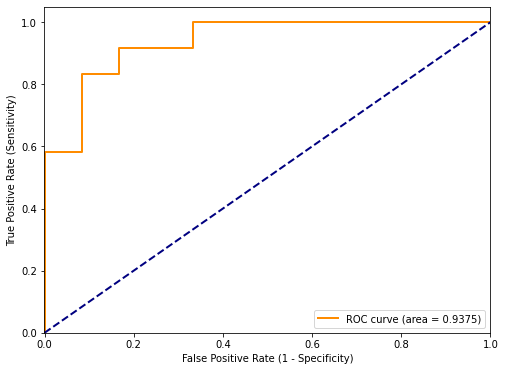

In [11]:
# compute de ROC curve and AUC
fpr, tpr, _ = roc_curve([1 if c == "owner" else 0 for c in owner_df.Class],
                        owner_df.Probability)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange",
         lw=2, label="ROC curve (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend(loc="lower right")
plt.show()

### Asymmetric Misclassification Costs

Implicit in discussing the lift curve, which measures how effective we are in identifying the members of one particular class, is the assumption that the error of misclassifying a record belonging to one class is more serious than for the other class. For example, misclassifying a household as unlikely to respond to a sales offer when it belongs to the class that would respond incurs a greater cost (the opportunity cost of the foregone sale) than the converse error. In the former case, you are missing out on a sale worth perhaps tens or hundreds of dollars. In the latter, you are incurring the costs of contacting someone who will not purchase. In such a scenario, using the misclassification rate as a criterion can be misleading.

Note that we are assuming that the cost (or benefit) of making correct classifications is zero. At first glance, this may seem incomplete. After all, the benefit (negative cost) of classifying a buyer correctly as a buyer would seem substantial. And in other circumstances (e.g., scoring our classification algorithm to fresh data to implement our decisions), it will be appropriate to consider the actual net dollar impact of each possible classification (or misclassification). Here, however, we are attempting to assess the value of a classifier in terms of classification error, so it greatly simplifies matters if we can capture all cost/benefit information in
the misclassification cells. So, instead of recording the benefit of classifying a respondent household correctly, we record the cost of failing to classify it as a respondent household. It amounts to the same thing and our goal becomes the minimization of costs, whether the costs are actual costs or missed benefits (opportunity costs).

Consider the situation where the sales offer is mailed to a random sample of people for the purpose of constructing a good classifier. Suppose that the offer is accepted by 1% of those households. For these data, if a classifier simply classifies every household as a nonresponder, it will have an error rate of only 1% but it will be useless in practice. A classifier that misclassifies 2% of buying households as nonbuyers and 20% of the nonbuyers as buyers would have a higher error rate but would be better if the profit from a sale is substantially
higher than the cost of sending out an offer. In these situations, if we have estimates of the cost of both types of misclassification, we can use the confusion matrix to compute the expected cost of misclassification for each record in the validation data. This enables us to compare different classifiers using overall expected costs (or
profits) as the criterion.

Suppose that we are considering sending an offer to 1000 more people, where on average 1% of whom respond (1). Naively, classifying everyone as a 0 has an error rate of only 1%. Using a data mining routine, suppose that we can produce these classifications:


|                   | Pred. Class 0    | Pred. Class 1   |
|:------------------|:-----------------|:----------------|
| **Actual Class 0**| 970              | 20              |
| **Actual Class 1**| 2                | 8               |

These classifications have an error rate of 100 × (20 + 2)/1000 = 2.2% — higher than the naive rate.

Now suppose that the **profit** from a responder is \\$10 and the **cost** of sending the offer is \\$1. Classifying everyone as a 0 still has a misclassification rate of only 1%, but yields a profit of \\$0. Using the data mining routine, despite the higher misclassification rate, yields a profit of \\$60, as 8 × 10 - 20 × 1.

The matrix of profit is as follows (nothing is sent to the predicted 0’s so there are no costs or sales in that column):

|                   | Pred. Class 0    | Pred. Class 1   |
|:------------------|:-----------------|:----------------|
| **Actual Class 0**| 0                | - \\$20         |
| **Actual Class 1**| 0                |   \\$80         |


Looked at purely in terms of costs, when everyone is classified as a 0, there are no costs of sending the offer; the only costs are the opportunity costs of failing to make sales to the ten 1’s = \\$100. The cost (actual costs of sending the offer, plus the opportunity costs of missed sales) of using the data mining routine to select people to send the offer to is only \\$48, as follows:

|                   | Pred. Class 0    | Pred. Class 1   |
|:------------------|:-----------------|:----------------|
| **Actual Class 0**| 0                |  \\$20          |
| **Actual Class 1**| \\$20            |   \\$8          |

However, this does not improve the actual classifications themselves. A better method is to change the classification rules (and hence the misclassification rates) as discussed in the preceding section, to reflect the asymmetric costs.

A popular performance measure that includes costs is the *average misclassification cost*, which measures the average cost of misclassification per classified record. Denote by $q_1$ the cost of misclassifying a class $C_1$ record (as belonging to class $C_2$) and by $q_2$ the cost of misclassifying a class $C_2$ record (as belonging to class $C_1$). The average misclassification cost is:

<p><center>$\frac{q_{1} n_{1, 2} + q_{2} n_{2, 1}}{n}$</center></p>

Thus, we are looking for a classifier that minimizes this quantity. This can be computed, for instance, for different cutoff values.

It turns out that the optimal parameters are affected by the misclassification costs only through the ratio of these costs. This can be seen if we write the foregoing measure slightly differently:

<p><center>$\frac{q_{1} n_{1, 2} + q_{2} n_{2, 1}}{n} = \frac{n_{1, 2}}{n_{1, 1} + n_{1, 2}}\frac{n_{1, 1} + n_{1, 2}}{n}q_{1} + \frac{n_{2, 1}}{n_{2, 1} + n_{2, 2}}\frac{n_{2, 1} + n_{2, 2}}{n}q_{2}$</center></p>

Minimizing this expression is equivalent to minimizing the same expression divided by a constant. If we divide by $q_1$ , it can be seen clearly that the minimization depends only on $\frac{q_2}{q_1}$ and not on their individual values. This is very practical, because in many cases it is difficult to assess the costs associated with misclassifying a $C_1$ member and a $C_2$ member, but estimating the ratio is easier.

This expression is a reasonable estimate of future misclassification cost if the proportions of classes $C_1$ and $C_2$ in the sample data are similar to the proportions of classes $C_1$ and $C_2$ that are expected in the future. If instead of a random sample, we draw a sample such that one class is oversampled, then the sample proportions of $C_1$’s and $C_2$’s will be distorted compared to the future or population. We can then correct the average misclassification cost measure for the distorted sample proportions by incorporating estimates of the true proportions (from external data or domain knowledge), denoted by $p(C_{1})$ and $p(C_{2})$, into the formula:

<p><center>$\frac{n_{1, 2}}{n_{1, 1} + n_{1, 2}} p(C_{1}) q_{1} + \frac{n_{2, 1}}{n_{2, 1} + n_{2, 2}} p(C_{2}) q_{2}$</center></p>

Using the same logic as above, it can be shown that optimizing this quantity depends on the costs only through their ratio $\frac{q_2}{q_1}$ and on the prior probabilities only through their ratio $[\frac{p(C_2)}{p(C_1)}]$. This is why software packages that incorporate costs and prior probabilities might prompt the user for ratios rather than actual costs and probabilities.